#ICA

This mini project focuses on exploring how ICA can be used to separate an image of a biological specimen that has been distorted by a random noise image. First, we apply preprocessing to the two mixed images, including centering the pixel values and applying whitening. Then, we apply ICA to recover the original biological specimen image, and the original noise distortion.


##Part 1 - Preparing the Data

This part of the assignment downloads the data from GitHub, converts the images to NumPy arrays, and displays the two images to check that we correctly read and processed the data.

**Dependencies**


This section contains all dependencies used for the rest of the code cells.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image

**Data Preparation**

The code cell below downloads the two image PNGs from GitHub. The images are then converted to NumPy arrays and displayed.


In [ ]:
!wget https://github.com/racs2019/A4ML/raw/main/Recording-1.png
!wget https://github.com/racs2019/A4ML/raw/main/Recording-2.png

--2024-03-12 15:40:07--  https://github.com/racs2019/A4ML/raw/main/Recording-1.png
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/racs2019/A4ML/main/Recording-1.png [following]
--2024-03-12 15:40:07--  https://raw.githubusercontent.com/racs2019/A4ML/main/Recording-1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 455049 (444K) [image/png]
Saving to: ‘Recording-1.png’

Recording-1.png     100%[===================>] 444.38K  --.-KB/s    in 0.03s   

2024-03-12 15:40:07 (12.8 MB/s) - ‘Recording-1.png’ saved [455049/455049]

--2024-03-12 15:40:07--  https://github.com/racs2019/A4ML/raw/main/Rec

In [ ]:
#Convert PNG to NumPy
img1_png = Image.open("Recording-1.png")
img1 = np.array(img1_png)

img2_png = Image.open("Recording-2.png")
img2 = np.array(img2_png)

[]

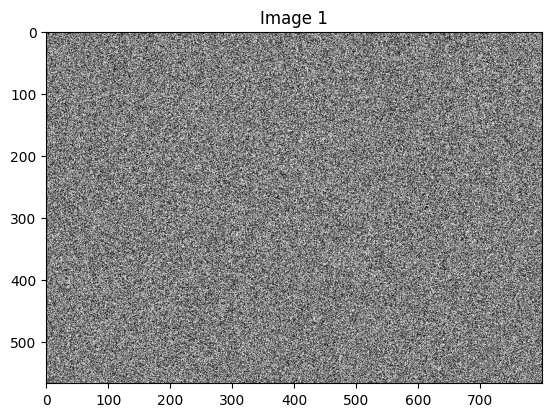

In [ ]:
#800 col by 567 row
plt.imshow(img1, cmap='gray')
plt.title('Image 1')
plt.plot()

[]

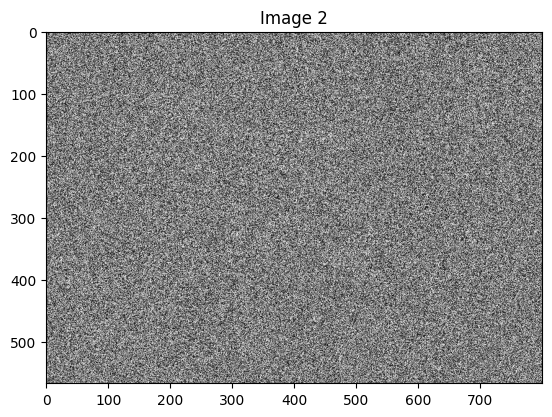

In [ ]:
#800 col by 567 row
plt.imshow(img2, cmap='gray')
plt.title('Image 2')
plt.plot()

##Part 2 - Data Preprocessing

This part of the assignment preprocesses the raw images by applying centering and whitening, which will already reduce a significant amount of noise from the biological image before applying ICA. This makes the ICA process converge faster based on my experiments while creating this project.

**Centering**

The code cells below center the data by subtracting the mean pixel value from each image.

In [ ]:
#Reshape and flatten image arrays
x = np.zeros((2,567*800))
x[0][:] = img1[:][:].reshape(1, 567*800)
x[1][:] = img2[:][:].reshape(1, 567*800)

In [ ]:
#Calculate mean pixel value for image 1
avex1 = 0
for i in range(567*800):
  avex1 = avex1 + x[0][i]
avex1 = avex1/(567*800)

#Subtract mean pixel value for image 1
for i in range(567*800):
  x[0][i] = x[0][i] - avex1

In [ ]:
#Calculate mean pixel value for image 2
avex2 = 0
for i in range(567*800):
  avex2 = avex2 + x[1][i]
avex2 = avex2/(567*800)

#Subtract mean pixel value for image 2
for i in range(567*800):
  x[1][i] = x[1][i] - avex2

**Whitening**

The code cells below calculate the covariance matrix of the data, and then uses the eigen values and eigen vectors of the covariance matrix to apply whitening to the image. The whitened image is then printed, which shows how big of an impact on restoring the image whitening has before even applying ICA.

In [ ]:
#Calculate covariance
cov_matrix = np.cov(x)

#Calculate eigen vectors/values
V, Q = np.linalg.eig(cov_matrix)

#Apply whitening
x_tilda = np.dot(np.dot(np.dot(Q, np.diag(np.power(V, -0.5))), np.transpose(Q)), x)

[]

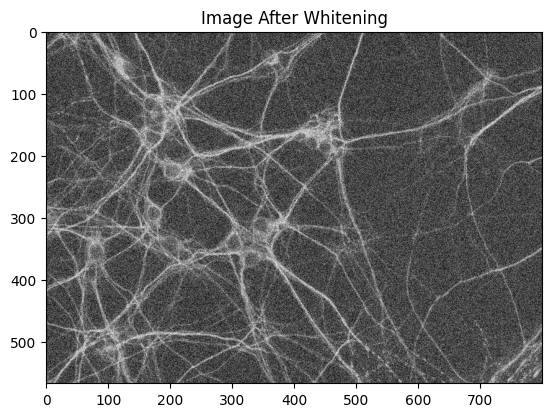

In [ ]:
#Display whitened image
plt.imshow(x_tilda[1].reshape(567, 800), cmap='gray')
plt.title('Image After Whitening')
plt.plot()

##Part 3 - Fast ICA

This part of the project applies the main Fast ICA algorithm to the two mixed images in order to recover the original noise distortion image and the original biological specimen image. After the parameters W is computed from the ICA, we shift the data back to the original pixel values (uncenter) and plot the recovered signals/images.

**Derivative Functions**

The code cell below contains the function that approximates negative entropy, G(x) = -e^(-(x^2)/2), as well as its derivative and second derivative for use in the main ICA algorithm loop.

In [ ]:
def G(x):
  return (-math.exp(-(x**2)/2))
def g(x):
  return (x*math.exp(-(x**2)/2))
def g_prime(x):
  return (-(x**2)*math.exp(-(x**2)/2) + math.exp(-(x**2)/2))

**Main Fast ICA Loop**

The code cell below contains the main ICA algorithm. In step 1, a vector of shape 2,1 is randomly initialized between integers of -100 to 100 for vector W. In step 2, we then loop through the update rule using the derivative functions until W stagnates. After each iteration, W must be normalized, which occurs in step 3. The loop is repeated 30 times (step 4) since that allows the values of W to converge.

In [ ]:
#Use the pre-processed (centered and whitened) image
x = x_tilda

#Step 1
W = np.random.randint(-100, 100, (2,1))
print('Initial W:\n', W)

#Step 2
for iterations in range(30):
  ave_1 = 0
  for i in range(567*800):
    ave_1 = ave_1 + g_prime(np.dot(np.transpose(W), [x[0][i], x[1][i]]))
  ave_1 = ave_1/(567*800)

  ave_2 = [0,0]
  for i in range(567*800):
    temp = (g(np.dot(np.transpose(W), [x[0][i], x[1][i]])))
    ave_2[0] = ave_2[0] + x[0][i] * temp
    ave_2[1] = ave_2[1] + x[1][i] * temp
  ave_2[0] = ave_2[0]/567*800
  ave_2[1] = ave_2[1]/567*800
  W = ave_2 - (ave_1 * W)

  #Step 3
  W = (W) / (math.sqrt(W[0]**2 + W[1]**2))
  print('Iteration:', iterations, 'W:\n', W)

#Step 4 (loop until convergance)
print('Final W:\n', W)

Initial W:
 [[ -5]
 [-34]]


<ipython-input-11-d6547a43e29d>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (-(x**2)*math.exp(-(x**2)/2) + math.exp(-(x**2)/2))
<ipython-input-11-d6547a43e29d>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (x*math.exp(-(x**2)/2))
<ipython-input-12-0e7387f13901>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W = (W) / (math.sqrt(W[0]**2 + W[1]**2))


Iteration: 0 W:
 [[-0.63011208]
 [-0.7765042 ]]
Iteration: 1 W:
 [[-0.67637727]
 [-0.73655536]]
Iteration: 2 W:
 [[-0.69980155]
 [-0.7143373 ]]
Iteration: 3 W:
 [[-0.71148951]
 [-0.70269672]]
Iteration: 4 W:
 [[-0.71733379]
 [-0.69672967]]
Iteration: 5 W:
 [[-0.7202675 ]
 [-0.69369642]]
Iteration: 6 W:
 [[-0.72174416]
 [-0.69215992]]
Iteration: 7 W:
 [[-0.72248859]
 [-0.69138284]]
Iteration: 8 W:
 [[-0.72286419]
 [-0.69099013]]
Iteration: 9 W:
 [[-0.72305379]
 [-0.69079174]]
Iteration: 10 W:
 [[-0.72314951]
 [-0.69069153]]
Iteration: 11 W:
 [[-0.72319784]
 [-0.69064092]]
Iteration: 12 W:
 [[-0.72322225]
 [-0.69061536]]
Iteration: 13 W:
 [[-0.72323457]
 [-0.69060246]]
Iteration: 14 W:
 [[-0.7232408 ]
 [-0.69059594]]
Iteration: 15 W:
 [[-0.72324394]
 [-0.69059265]]
Iteration: 16 W:
 [[-0.72324553]
 [-0.69059098]]
Iteration: 17 W:
 [[-0.72324633]
 [-0.69059014]]
Iteration: 18 W:
 [[-0.72324673]
 [-0.69058972]]
Iteration: 19 W:
 [[-0.72324694]
 [-0.69058951]]
Iteration: 20 W:
 [[-0.7232470

**Display Signal 1 After Fast ICA**

The code cells below uncenter the data to shift the recovered data back to the original values and plot the recovered image 1.

In [ ]:
#Uncenter the data for signal 1
mean_of_W1 = np.dot(np.transpose(W), [avex1, avex2])

x_final = np.dot(np.transpose(W), x)
for i in range(567*800):
  x_final[0][i] = x_final[0][i] + mean_of_W1

<ipython-input-13-0aaa7fbe1ff1>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_final[0][i] = x_final[0][i] + mean_of_W1


[]

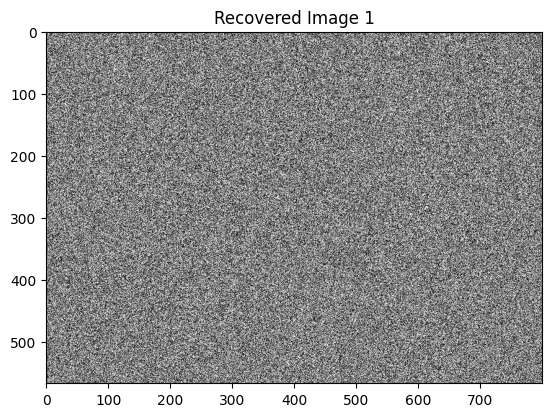

In [ ]:
#Display the separated signal 1
plt.imshow(x_final[0].reshape(567, 800), cmap='gray')
plt.title('Recovered Image 1')
plt.plot()

**Display Signal 2 After Fast ICA**

The code cells below uncenter the data to shift the recovered data back to the original values and plot the recovered image 2. The colors of image 2 are then inversed to display the flipped version of the image as well.


In [ ]:
#Find the orthogonal vector for signal 2
temp = W[0]
W[0] = W[1]
W[1] = -temp

In [ ]:
#Uncenter the data for signal 2
mean_of_W2 = np.dot(np.transpose(W), [avex1, avex2])

x_final = np.dot(np.transpose(W), x)
for i in range(567*800):
  x_final[0][i] = x_final[0][i] + mean_of_W2

<ipython-input-16-d79891c152a2>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_final[0][i] = x_final[0][i] + mean_of_W2


[]

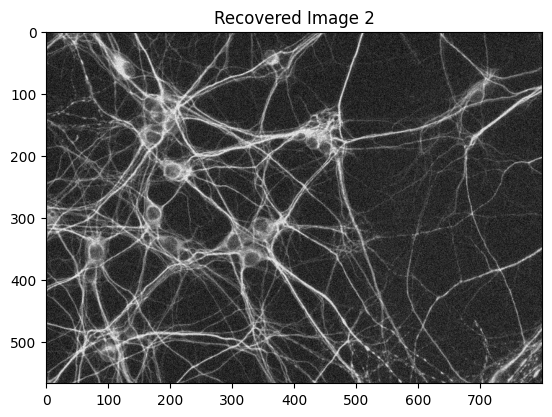

In [ ]:
#Display the separated signal 2
plt.imshow(x_final[0].reshape(567, 800), cmap='gray')
plt.title('Recovered Image 2')
plt.plot()

In [ ]:
#Flip the colors of the image
W[0] = -W[0]
W[1] = -W[1]

[]

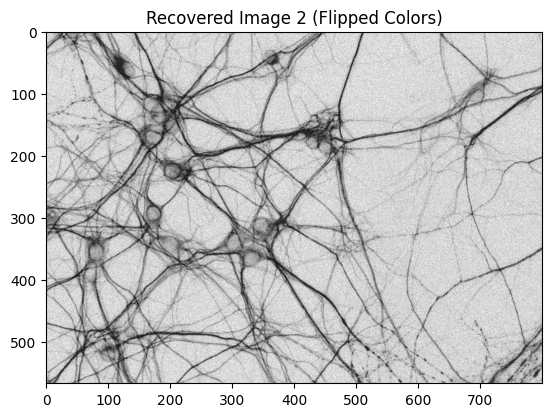

In [ ]:
#Display the separated signal 2 with flipped colors
x_final = np.dot(np.transpose(W), x)
plt.imshow(x_final[0].reshape(567, 800), cmap='gray')
plt.title('Recovered Image 2 (Flipped Colors)')
plt.plot()